In [1]:
# Load the python modules.
import os, sys
#Insert the common folder in the path (to be able to load python module)
sys.path.insert(0,os.path.join(os.path.pardir,'common'))
import numpy as np
from dapper import Chronology

from toolbox import load_config, path, get_filenames, load_data, rmse_norm
from l2s_utils import plot_L96_2D

#To control plot layouts
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

from tqdm.notebook import tqdm

Initializing DAPPER...

but is not supported by current backend: module://ipykernel.pylab.backend_inline.
Try another backend in your settings, e.g., mpl.use('Qt5Agg').
...Done
PS: Turn off this message in your configuration: dpr_config.ini


# Setting

## Source of the data
The variable ```source``` can be set to ```"ftp"``` or ```"local"```.
- ```ftp```: it will download the data from an ftp server, so there is no need to compute the data. WARNING: it will override existing data in the data simulations data directory.
- ```local```: it will load the data locally. So you have to first either having downloaded the data from the ftp server, either having computing the data using the other notebooks.

## Configuration files
There are 4 configuration file to set. Default configuration files are provided but if you want to make further experiment, it is possible to change the configuration file.
- ```config_path```: contains the path of the data directory.
- ```config_ftp```: contains the url of the data in the ftp server. This configuration file is optional if you don't download the data from ftp.
- ```config_ref```: contains the reference simulations settings.
- ```config_sens```: contains the different settings for an sensitivity experiment.

In [2]:
#Source of the data (comment/uncomment the lines given your choice)
source = 'local'
#source = 'ftp'


In [19]:
# Directory where to save the figure (if figdir = None, no figure are saved)
figdir = '.'
#figdir = None

In [20]:
# Configuration files
config_path = 'config/paths.yml'
config_ftp = 'config/ftp.yml' #optional if data are generated locally
config_ref = 'config/ref_test.yml'
config_sens = 'config/sens_test.yml'
config_sens_po = 'config/sens_test_po.yml'

In [21]:
# Load the paths (yml file)
paths = load_config(config_path)

# Load the reference
ref = load_config(config_ref)

# Rootdir for the L2S data
rootdir = path(paths['rootdir'])

# Template names
template_ref = ref['template']

#Check if figdir exist and set the figdir bool accordingly
savefig = bool(figdir)

#Directory containing the simulations
refdir = path(os.path.join(rootdir,ref['savedir']))

#Print:
print("Directory containing the simulations for the reference experiment:\n->",refdir)


Directory containing the simulations for the reference experiment:
-> /Group/da/julaja/redda/L2S/simul/test


In [22]:
#Load the ftp configuration file if needed
if source == 'ftp':
    ftp = load_config(config_ftp)
    ftpurl, ftpdir = ftp['url'], ftp['test']
    print('\033[93m'+'Warning! The source is set to ftp. \nIt will override existing local simulation in the simulation directory'+'\033[0m')
else:
    ftp = None
    ftpurl, ftpdir = None, None

## Plot Figure 1

In [23]:

# Define the parameters
used_parameter = { 'p', 'std_o', 'dtObs', 'std_m' ,'N','T','seed', 'Nfil_train'}

#List of values for the used paramters
dparam = {k:ref.get(k,[default_param[k]])[0] for k in used_parameter}



used_parameters = { 'p', 'std_o', 'dtObs', 'std_m' ,'N','T','seed'}
print('Parameters of the reference experiment:\n',dparam)


Parameters of the reference experiment:
 {'p': 36, 'N': 20, 'T': 15.0, 'dtObs': 0.05, 'std_o': 0.1, 'std_m': 0.06, 'seed': 10, 'Nfil_train': 1}


In [24]:
# Load the data of the true run
fname_truth = template_ref['truth'].format(**dparam)
print('Load truth simulation:',fname_truth)
data_truth = load_data(refdir,fname_truth,ftpurl=ftpurl,ftpdir=ftpdir)

# Load the data of the hybrid run
fname_hybrid = template_ref['hybrid'].format(**dparam)
print('Load hybrid simulation:', fname_hybrid)
data_hybrid = load_data(refdir,fname_hybrid,ftpurl=ftpurl,ftpdir=ftpdir)

Load truth simulation: simul-truth-T15.0-N20-seed10.npz
Load hybrid simulation: simul-hybrid-p36-dtObs0.05-std_o0.1-filter1-N20-seed10.npz


In [25]:
# Format the data (the time step of the hybrid model is different from the time step of the real model)

#hybrid data
xx_hybrid = data_hybrid['xx']

#chronology
chrono_hybrid = Chronology(dkObs=1,T=data_hybrid['T'],dt=float(data_hybrid['dt']))
chrono_truth = Chronology(dkObs=1,T=data_truth['T'],dt=float(data_truth['dt']))

#Compute the time step subsample:
dk = int(chrono_hybrid.dt/chrono_truth.dt)

#Compute the size of the hybrid model stat:
nU = xx_hybrid.shape[-1]

#Subsampe the true model in space and time to fit the hybrid model space
xx_truth = data_truth['xx'][::dk,:,:nU]

#Define the time axis
tt = chrono_hybrid.tt

#Display the size of the model simulations
print('Size of the time axis:',tt.shape)
print('Size of the truth simulation (time step, members, space):',xx_truth.shape)
print('Size of the hybrid simulation (time step, members, space):',xx_hybrid.shape)

Size of the time axis: (1501,)
Size of the truth simulation (time step, members, space): (1501, 20, 36)
Size of the hybrid simulation (time step, members, space): (1501, 20, 36)


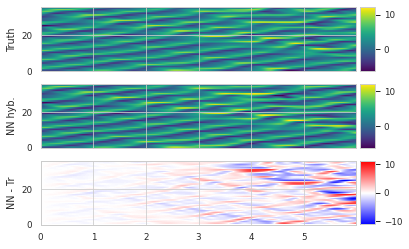

In [26]:
# Plot the figure 1

#Ensemble member to plot:
iens=6

#Number of time steps to plot
limT = 600

#Plot
fig = plot_L96_2D(xx_truth[:limT,iens],xx_hybrid[:limT,iens],tt[:limT],['Truth','NN hyb.'])

#Save (if needed)
if figdir:
    fig.savefig(os.path.join(figdir,'philtra-fig1.png'),
            dpi=200, bbox_inches='tight', pad_inches=0)